<a href="https://colab.research.google.com/github/clu97123/CAIS_Winter_Project/blob/main/CAIS_Winter_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to GPU runtime
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# import dataset from Google drive
from google.colab import drive
drive.mount('/content/drive/')
train_dir = '/content/drive/MyDrive/Colab Notebooks/cais_winter/Sarcasm_Headlines_Dataset_v2.json'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install transformers

In [4]:
# create DataFrame from json file
import pandas as pd
df = pd.read_json(train_dir, lines = True)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))


Number of training sentences: 28,619



In [5]:
# the article_link column isn't necessary so we only take the values for headline and is_sarcastic
headlines = df.headline.values
labels = df.is_sarcastic.values

In [6]:
# download pretrained BERT model
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# find max length for padding each headline
max_len = 0

for line in headlines:
    input_ids = tokenizer.encode(line, add_special_tokens=True)

    if max_len < len(input_ids):
        max_len = len(input_ids)

print("Max headline length: ", max_len)

Max headline length:  193


In [8]:
# encode each headline by adding special tokens, padding, and finding attention
input_ids = []
attention_masks = []

for line in headlines:
    encoded_dict = tokenizer.encode_plus(line,
                                      add_special_tokens = True,
                                      max_length = max_len,
                                      pad_to_max_length = True,
                                      return_attention_mask = True,
                                      return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
# split dataset into training, validation, and testing datasets
from torch.utils.data import TensorDataset, random_split

# set a manual seed so we can keep the same headlines in each subset
generator = torch.Generator()
generator.manual_seed(52)

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

# 64% of data used for training, 16% for validation, and 20% for testing
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))
print('{:>5,} testing samples'.format(len(test_dataset)))

18,316 training samples
4,579 validation samples
5,724 testing samples


In [10]:
# create DataLoaders for training and validation datasets
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size,)
val_dataloader = DataLoader(val_dataset,
                            sampler = SequentialSampler(val_dataset),
                            batch_size = batch_size)

In [11]:
# set up model, push to GPU
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
# set up optimizer, lr and eps are the same as the lesson 4 notebook
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 2e-5,
                             eps = 1e-8)

In [13]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
# total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [14]:
# set up a calculating flat_accuracy function for tuples
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
# set up a time function to keep track during training
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Training aka this is when my laptop explodes
# Takes about 20 minutes on average

import random
import numpy as np

# set seed for reproducible results
seed_val = 52

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels,
                      return_dict=True)
        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Validation time oh my godd!!!!
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(val_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    573.    Elapsed: 0:00:39.
  Batch    80  of    573.    Elapsed: 0:01:20.
  Batch   120  of    573.    Elapsed: 0:01:59.
  Batch   160  of    573.    Elapsed: 0:02:40.
  Batch   200  of    573.    Elapsed: 0:03:20.
  Batch   240  of    573.    Elapsed: 0:04:01.
  Batch   280  of    573.    Elapsed: 0:04:41.
  Batch   320  of    573.    Elapsed: 0:05:21.
  Batch   360  of    573.    Elapsed: 0:06:02.
  Batch   400  of    573.    Elapsed: 0:06:42.
  Batch   440  of    573.    Elapsed: 0:07:22.
  Batch   480  of    573.    Elapsed: 0:08:03.
  Batch   520  of    573.    Elapsed: 0:08:43.
  Batch   560  of    573.    Elapsed: 0:09:23.

  Average training loss: 0.29
  Training epoch took: 0:09:36

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
  Validation took: 0:00:55

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    573.    Elapsed: 0:00:40.
  Batch    80  of    573.    Elapsed: 0:01:20.
  Batch  

In [16]:
# load saved model (external library), when I want to skip training the whole model
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/cais_winter/CAIS_Winter_model.pth')
print(state_dict.keys())
model.load_state_dict(state_dict)

odict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output

<All keys matched successfully>

In [17]:
# preparing to test the model on the test dataset
# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)


In [18]:
print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,724 test sentences...
    DONE.


In [19]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-30-4b959dcb1447>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


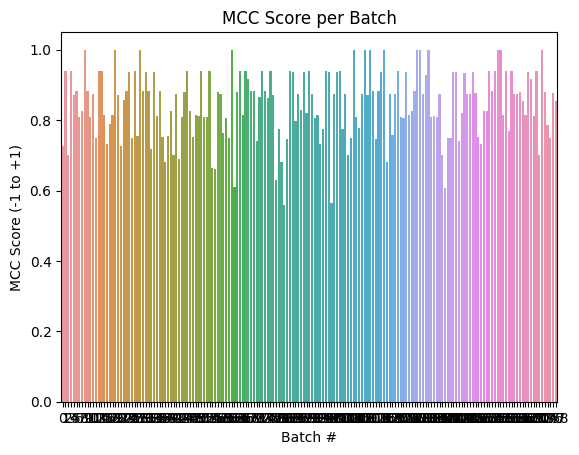

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [20]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.846


In [21]:
# Calculate accuray, precision, and recall scores

from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)

print('Total accuracy score: %.3f' % accuracy)
print('Total precision score: %.3f' % precision)
print('Total recall score: %.3f' % recall)

Total accuracy score: 0.923
Total precision score: 0.926
Total recall score: 0.910


In [25]:
# load my own dataset (external library) for further testing
my_data_dir = '/content/drive/MyDrive/Colab Notebooks/cais_winter/headlines_test.csv'
my_data_df = pd.read_csv(my_data_dir)
print('Number of training sentences: {:,}\n'.format(my_data_df.shape[0]))
my_data_headlines = my_data_df.headline.values
my_data_labels = my_data_df.is_sarcastic.values

Number of training sentences: 10



In [26]:
# find max length for padding each headline
my_data_max_len = 0

for line in my_data_headlines:
    input_ids = tokenizer.encode(line, add_special_tokens=True)

    if my_data_max_len < len(input_ids):
        my_data_max_len = len(input_ids)

print("Max headline length: ", my_data_max_len)

# encode each headline by adding special tokens, padding, and finding attention
input_ids = []
attention_masks = []

for line in my_data_headlines:
    encoded_dict = tokenizer.encode_plus(line,
                                      add_special_tokens = True,
                                      max_length = my_data_max_len,
                                      pad_to_max_length = True,
                                      return_attention_mask = True,
                                      return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
my_data_labels = torch.tensor(my_data_labels)

Max headline length:  23


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
# preparing to test the model on the test dataset
# Set the batch size, same as when training the model so it performs the same
batch_size = 32

# Create the DataLoader.
my_dataset = TensorDataset(input_ids, attention_masks, my_data_labels)
my_data_sampler = SequentialSampler(my_dataset)
my_dataloader = DataLoader(my_dataset, sampler=my_data_sampler, batch_size=batch_size)

In [28]:
print('Predicting labels for {:,} test sentences...'.format(len(my_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in my_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10 test sentences...
    DONE.


In [39]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# display original data with true labels and predicted labels
my_data_df.insert(1, 'predicted_is_sarcastic', flat_predictions)
display(my_data_df)

,is_sarcastic,predicted_is_sarcastic,headline,article_link
0,0,0,uk prime minister boris johnson sends unsigned...,https://www.huffpost.com/entry/boris-johnson-e...
1,0,0,arkansas sheriff resigns after he's caught on ...,https://www.huffpost.com/entry/todd-wright-rac...
2,0,0,mexican lawmakers advance bill to legalize rec...,https://www.huffpost.com/entry/mexico-legalize...
3,0,0,russia claims control of pivotal eastern ukrai...,https://www.huffpost.com/entry/russia-claims-c...
4,0,1,inmate stuck on u.s. death row despite vacated...,https://www.huffpost.com/entry/bruce-webster-d...
5,1,1,driver kind of bummed to see other car he been...,https://www.theonion.com/driver-kind-of-bummed...
6,1,1,woman tries to spark casual chat in long groce...,https://www.theonion.com/woman-tries-to-spark-...
7,1,1,researchers discover galaxy-sized goldfish ast...,https://www.theonion.com/researchers-discover-...
8,1,0,worst career advice baby boomers give millennials,https://www.theonion.com/worst-career-advice-b...
9,1,1,self-driving tesla regurgitates pedestrian to ...,https://www.theonion.com/self-driving-tesla-re...


In [ ]:
# download model so it can be tested on another runtime without having to train the whole thing again
from google.colab import files
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/cais_winter/CAIS_Winter_model.pth')
files.download('/content/drive/MyDrive/Colab Notebooks/cais_winter/CAIS_Winter_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>